In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import glob
import os

from collections import defaultdict
import pprint

from torchsummary import summary

from unet.training_loop import calc_loss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
model_names = glob.glob('checkpoints/simple_train_dom1_*pth')
model_names = np.sort(model_names)[1::2]
print(model_names)
model_name = model_names[0]

['checkpoints/simple_train_dom1_0.85pth'
 'checkpoints/simple_train_dom1_0.89pth'
 'checkpoints/simple_train_dom1_0.93pth'
 'checkpoints/simple_train_dom1_0.9700000000000001pth']


In [5]:
model = torch.load(model_name)
model = model.to(device)
model.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [6]:
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

#### Training/Testing Domains

**Training Dom 1:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.04, 0.06]  

---

**Testing Dom 1:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.04, 0.06]  

---


**Testing Dom 2:** 

Only rectangles with the following noise parameters  
start = (64, 192)  
extent = 64  
sigma_range = [0.04, 0.06]  

---


**Testing Dom 3:** 

Only circles with the following noise parameters  
center_extent = (64, 192)  
radius_extent = 64  
sigma_range = [0.08, 0.12]  

---


In [21]:
def inferOnDomain(dataPath, isMetrics=True, isPlot=True):
    d = np.load(dataPath)
    x, y = d['x'], d['y']
#     x.shape, y.shape
    
    #shuffle x and y
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    
    offset = 24
    x, y  = x[:offset], y[:offset]

    yNot = np.logical_not(y)
    y = np.concatenate([y, yNot], axis = 1)
    
    x = torch.as_tensor(x, dtype = torch.float)
    x = x.to(device=device)
    
    y_pred = model(x)
    y_pred = y_pred.cpu().detach().numpy()
    y_bin = (y_pred>0.5)*1.0

#     y_pred = (y_pred>0.7)*1.0
    x = x.cpu().detach().numpy()

    if isPlot:
        plt.figure(figsize = (10,40))
        for i in range(offset):
            plt.subplot(offset, 3, i*3+1)
            plt.imshow(x[i,0, :,:], cmap = 'gray')
            
            plt.subplot(offset, 3, i*3+2)
            plt.imshow(y_bin[i,0, :,:], cmap = 'gray')
            
            plt.subplot(offset, 3, i*3+3)
            plt.imshow(y[i,0, :,:], cmap = 'gray')

        


    if isMetrics:
        metrics = defaultdict(float)
        print(y.shape, y_pred.shape)
        y = torch.as_tensor(y, dtype= torch.float)
        y_pred = torch.as_tensor(y_pred, dtype = torch.float)
        loss = calc_loss(y_pred, y, metrics)
        for k in metrics.keys():
            print("{}: {}".format(k, metrics[k]/offset))

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.09989044815301895
dice: 0.15867097675800323
loss: 0.1292807161808014


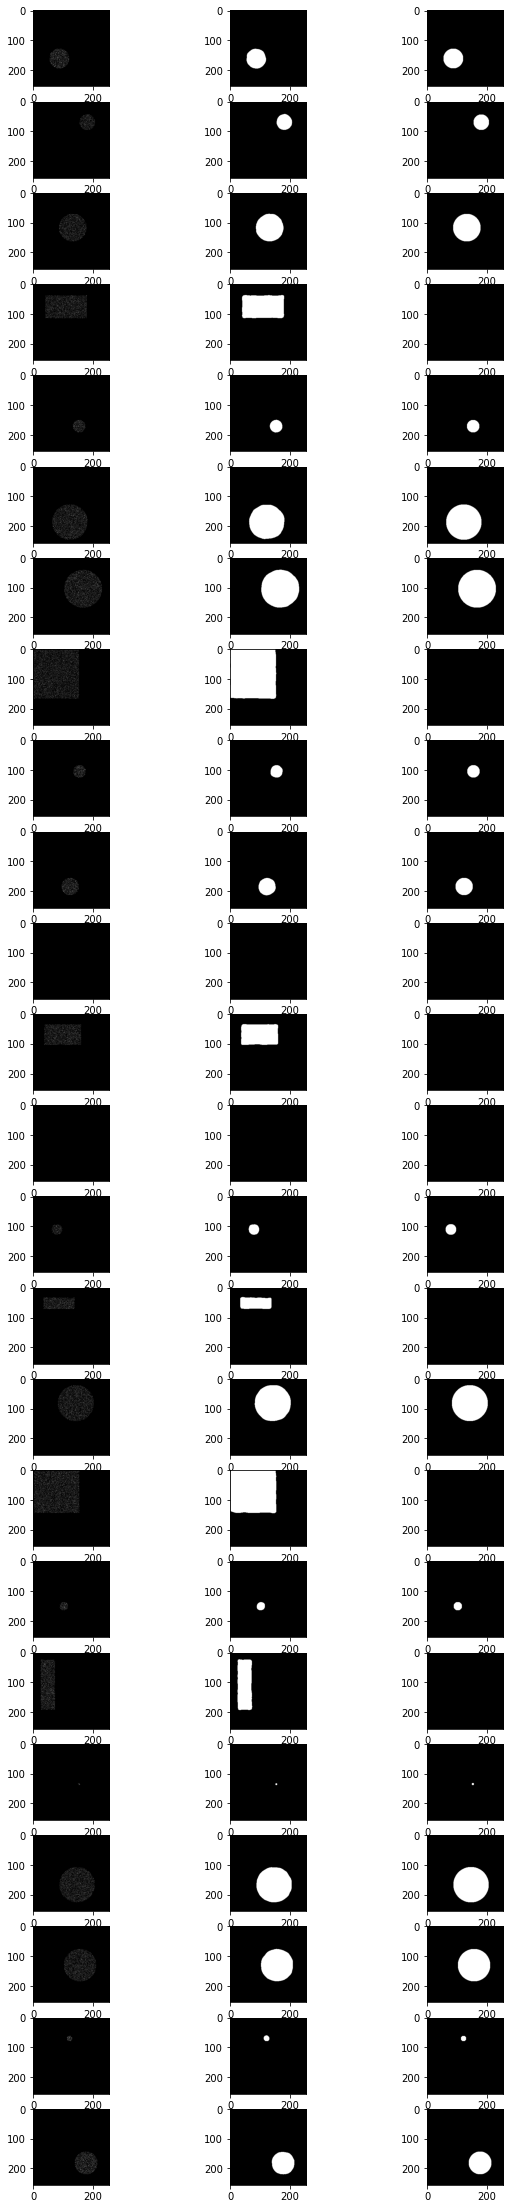

In [22]:
#Load train domain 1

dataPath = os.path.join('data/syntheticSegmentation', os.path.basename(model_name[:-len('pth')] + '.npz'))
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.015880107879638672
dice: 0.0458836667239666
loss: 0.030881887301802635


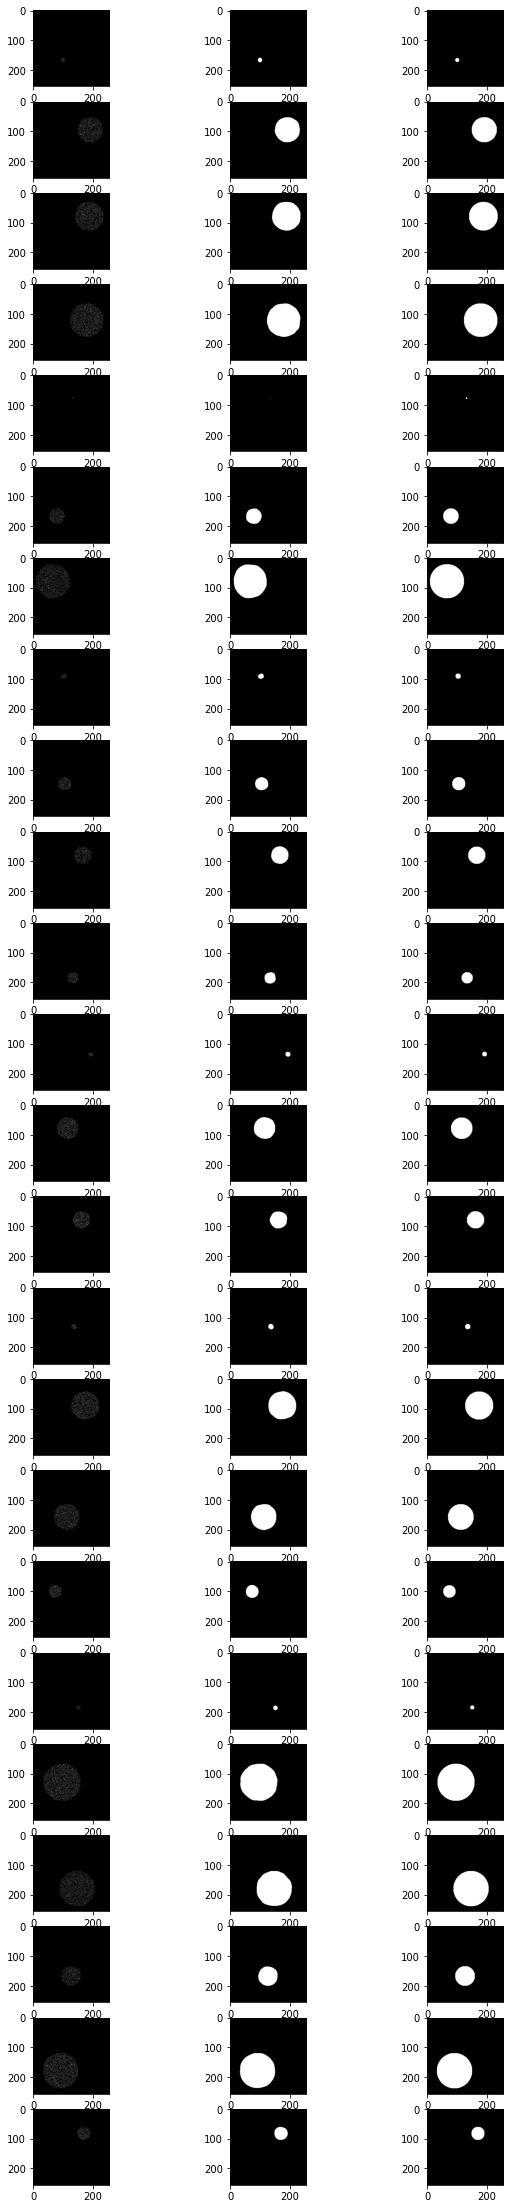

In [23]:
#Load test domain 1
dataPath = 'data/syntheticSegmentation/test_dom1.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 4.5327606201171875
dice: 0.46237727999687195
loss: 2.4975688457489014


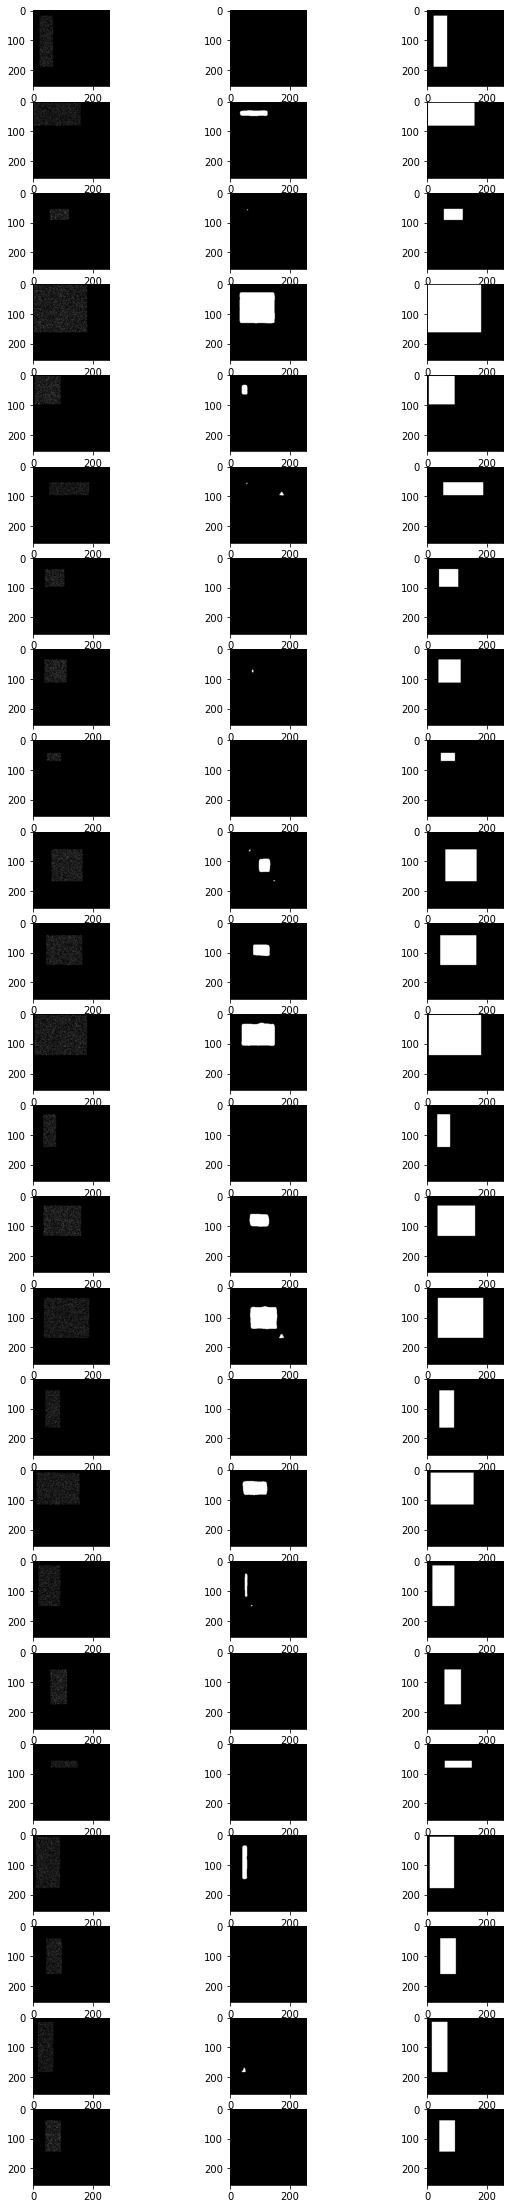

In [38]:
#Load test domain 2
dataPath = 'data/syntheticSegmentation/test_dom2.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 2.3020946979522705
dice: 0.5235863924026489
loss: 1.4128406047821045


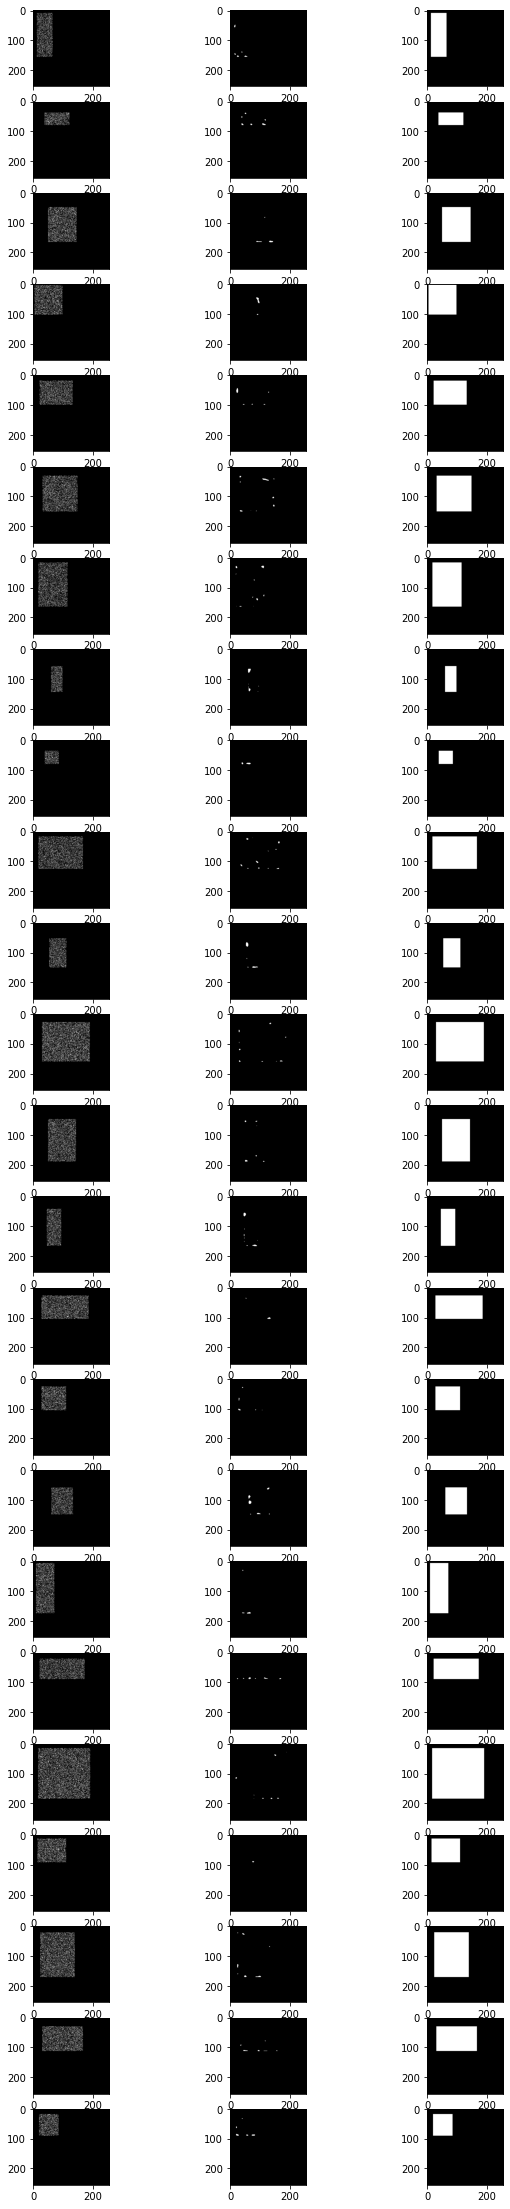

In [32]:
#Load test domain 7
dataPath = 'data/syntheticSegmentation/test_dom7.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 4.181568145751953
dice: 0.45053645968437195
loss: 2.316052198410034


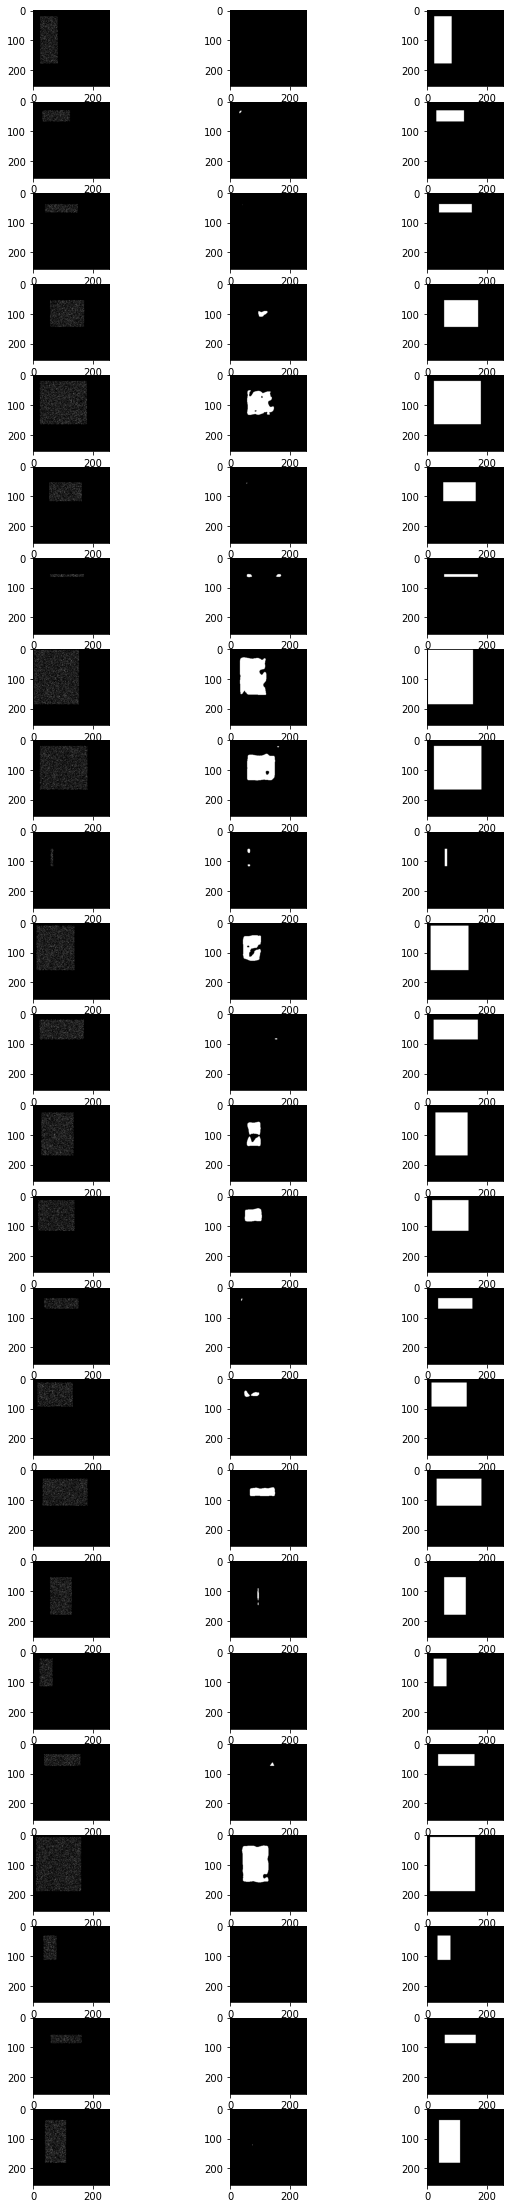

In [37]:
#Load test domain 8
dataPath = 'data/syntheticSegmentation/test_dom8.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.008452002890408039
dice: 0.03981083258986473
loss: 0.024131417274475098


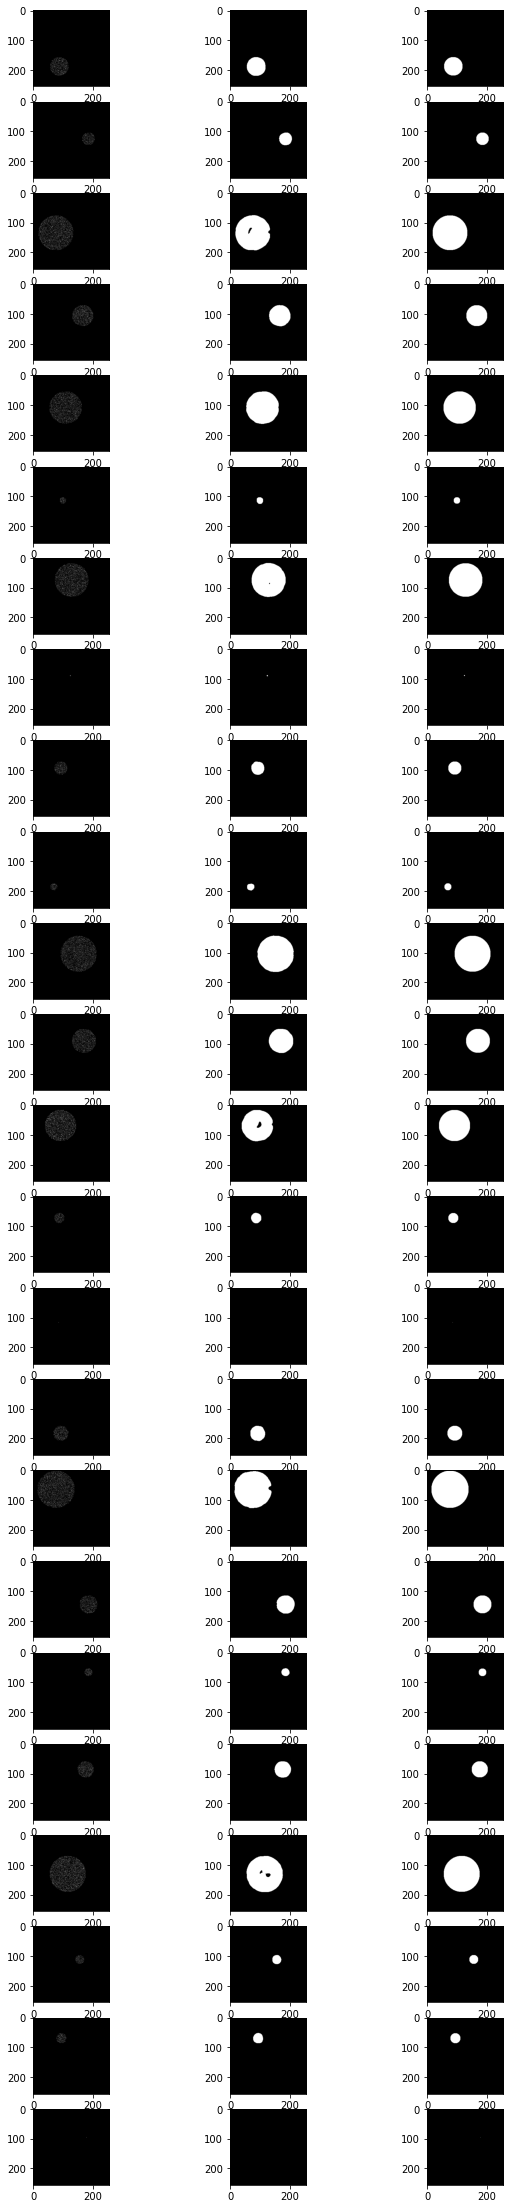

In [35]:
#Load test domain 3
dataPath = 'data/syntheticSegmentation/test_dom3.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 0.4437408745288849
dice: 0.2887401878833771
loss: 0.366240531206131


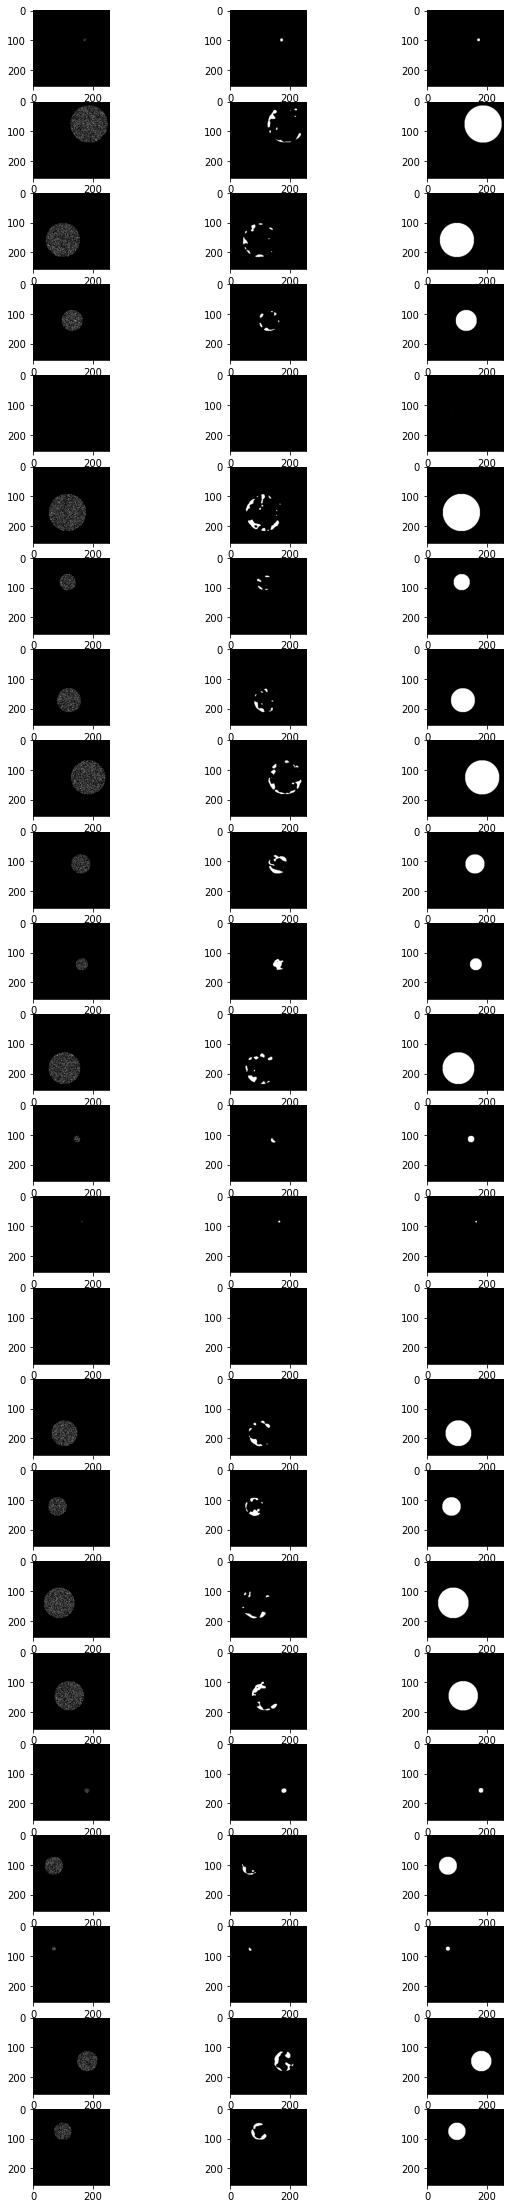

In [34]:
#Load test domain 4
dataPath = 'data/syntheticSegmentation/test_dom4.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 13.99227237701416
dice: 0.49389132857322693
loss: 7.243082046508789


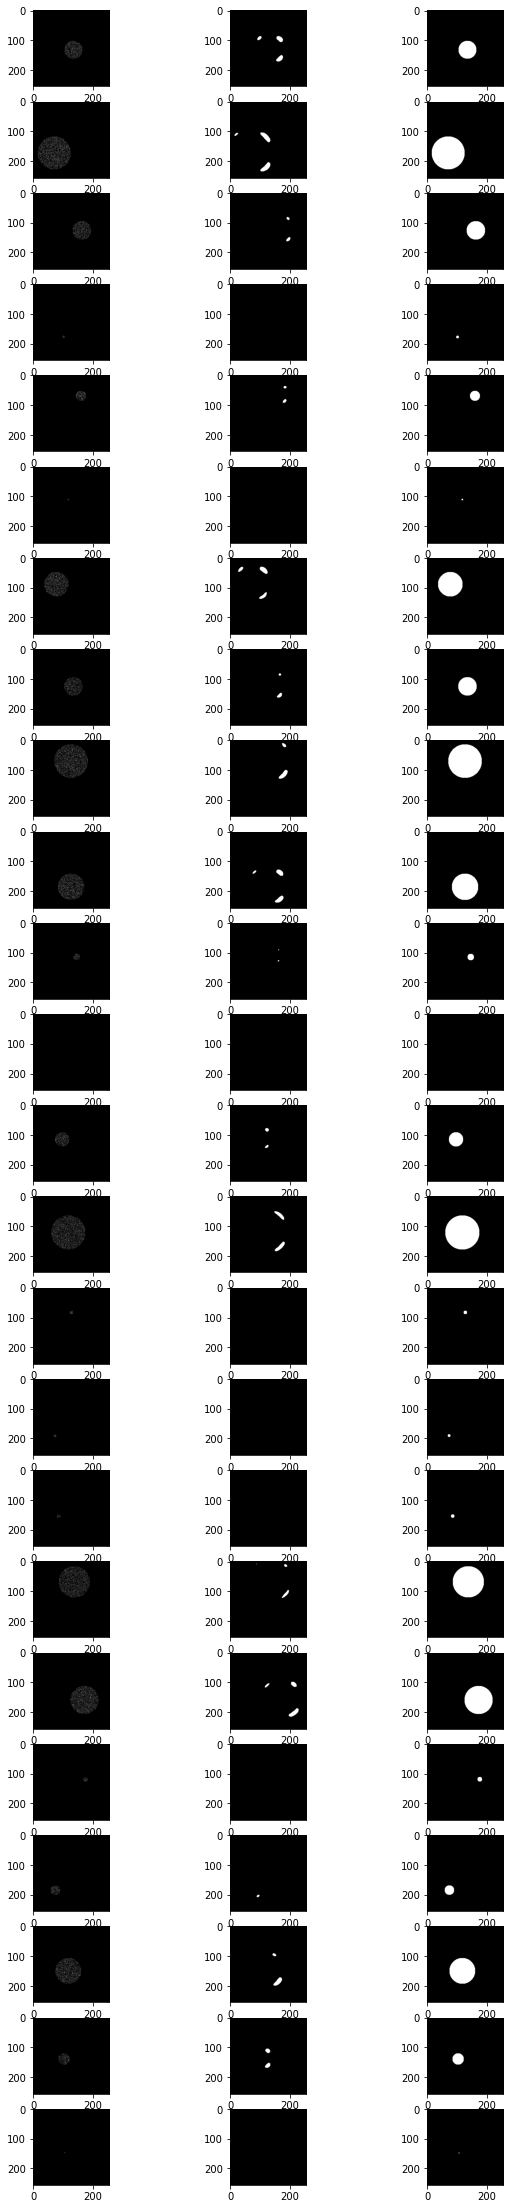

In [33]:
#Load test domain 5
dataPath = 'data/syntheticSegmentation/test_dom5.npz'
inferOnDomain(dataPath)

(24, 2, 256, 256) (24, 2, 256, 256)
bce: 60.91597366333008
dice: 0.946617603302002
loss: 30.93129539489746


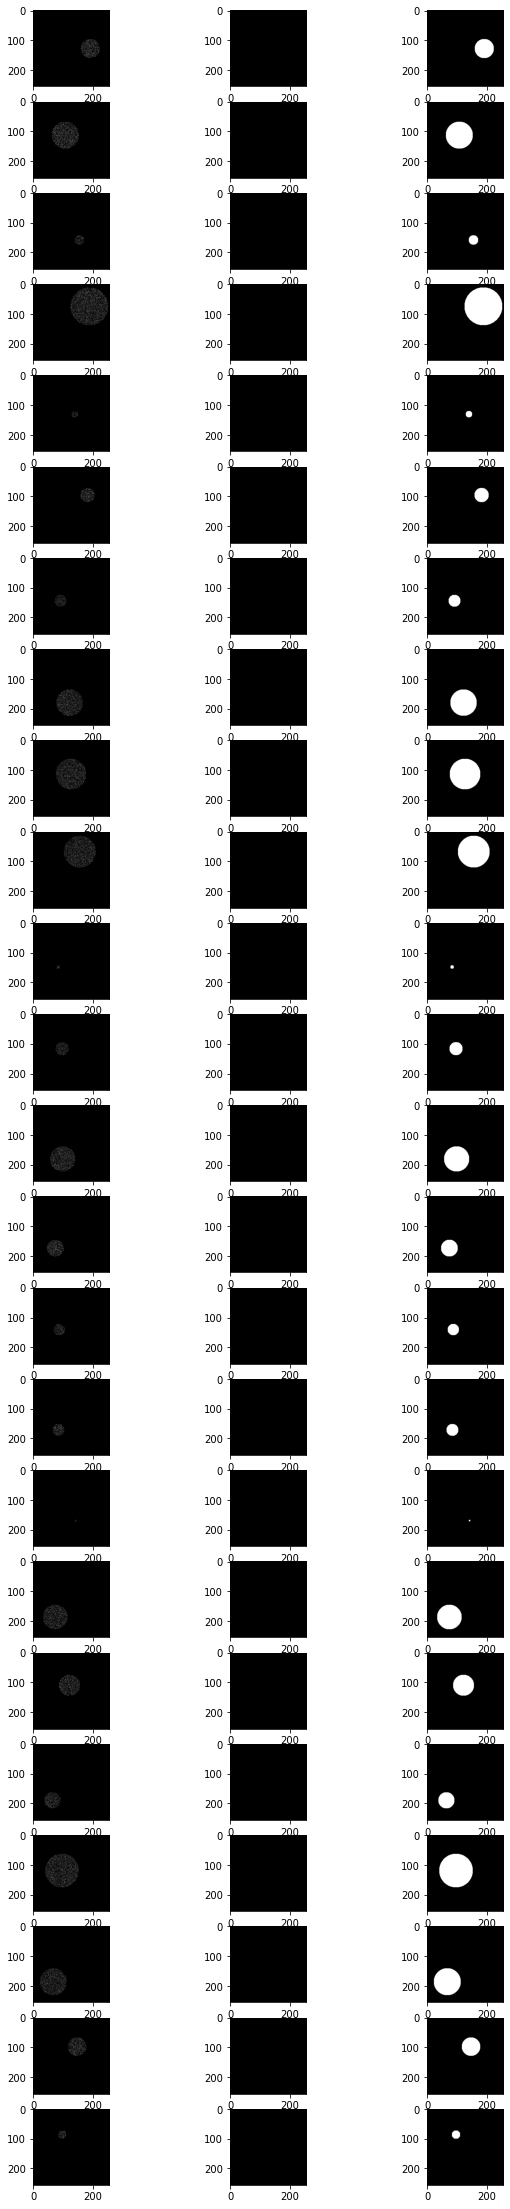

In [28]:
#Load test domain 6
dataPath = 'data/syntheticSegmentation/test_dom6.npz'
inferOnDomain(dataPath)

In [14]:
data = np.load("data/syntheticSegmentation/test_dom2.npz")
im, mask = data['x'], data['y']
im.shape, mask.shape

((256, 1, 256, 256), (256, 1, 256, 256))

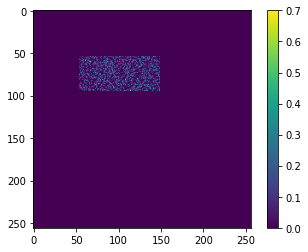

In [15]:
plt.imshow(im[7,0])
plt.colorbar()